In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

In [2]:
import os
import numpy as np
import natsort
from PIL import Image

case = input()
print('case :',case)

file_path = './heatmap_case'+str(case)+'_0.2'
file_list = os.listdir(file_path)
file_list = natsort.natsorted(file_list, key=None, reverse=False, alg=0)

num_of_files = len(file_list)

# Assuming all images have the same height and width
first_image = Image.open(os.path.join(file_path, file_list[0]))
height, width = np.array(first_image).shape

# Create an empty NumPy array to store the images
image_array = np.empty((num_of_files, height, width))

# Iterate through the file list and load images
for i, file_name in enumerate(file_list):
    image = Image.open(os.path.join(file_path, file_name))
    image_array[i] = np.array(image)

# image_array now contains the images as NumPy arrays
print(image_array.shape)  # (num_of_files, height, width)
print(file_list[:5])

(1300, 9, 64)
['train0.png', 'train1.png', 'train2.png', 'train3.png', 'train4.png']


In [3]:
import os
import numpy as np
from PIL import Image


num_of_frames = 13  # Specify the desired number of frames

# Assuming all images have the same height and width
first_image = Image.open(os.path.join(file_path, file_list[0]))
height, width = np.array(first_image).shape[:2]

# Create an empty NumPy array to store the images
dataset = np.empty((num_of_files-num_of_frames+1, num_of_frames, height, width))

# Iterate through the file list and load images
for i in range(num_of_files-num_of_frames+1):
    frame_images = file_list[i : i+num_of_frames]
    for j, file_name in enumerate(frame_images):
        if i < 2:
            print(file_name)
        image = Image.open(os.path.join(file_path, file_name))
        dataset[i, j] = np.array(image)
    if i < 2:
        print()

# dataset now contains the images bound into frames
print(dataset.shape)  # (num_of_files // num_of_frames, num_of_frames, height, width)

train0.png
train1.png
train2.png
train3.png
train4.png
train5.png
train6.png
train7.png
train8.png
train9.png
train10.png
train11.png
train12.png

train1.png
train2.png
train3.png
train4.png
train5.png
train6.png
train7.png
train8.png
train9.png
train10.png
train11.png
train12.png
train13.png

(1288, 13, 9, 64)


In [4]:
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)
dataset.shape #(num_of_samples, frames, height, width, channels)

(1288, 13, 9, 64, 1)

In [5]:
# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (1159, 12, 9, 64, 1), (1159, 12, 9, 64, 1)
Validation Dataset Shapes: (129, 12, 9, 64, 1), (129, 12, 9, 64, 1)


# Data Visualization

Displaying frames for example 1126.


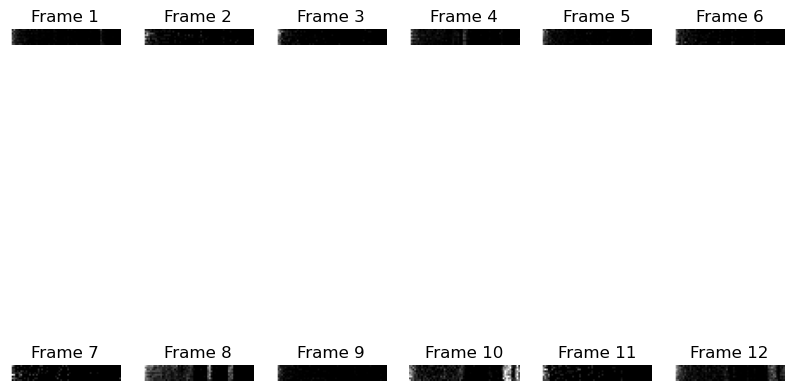

In [6]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(2, 6, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
np.random.seed(42)
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

# Model Construction

To build a Convolutional LSTM model, we will use the
`ConvLSTM2D` layer, which will accept inputs of shape
`(batch_size, num_frames, width, height, channels)`, and return
a prediction movie of the same shape.

In [7]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
convlstm = keras.models.Model(inp, x)
convlstm.compile(
    loss=tf.keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(),
)

# Model Training

With our model and data constructed, we can now train the model.

In [8]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 5

In [9]:
# Fit the model to the training data.

with tf.device("/gpu:0"):
    convlstm.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping, reduce_lr],
    )

Epoch 1/20
232/232 [==============================] - 158s 573ms/step - loss: 0.0076 - val_loss: 0.0205
Epoch 2/20
232/232 [==============================] - 137s 593ms/step - loss: 0.0013 - val_loss: 0.0101
Epoch 3/20
232/232 [==============================] - 324s 1s/step - loss: 7.4448e-04 - val_loss: 0.0016
Epoch 4/20
232/232 [==============================] - 354s 2s/step - loss: 6.2422e-04 - val_loss: 5.2132e-04
Epoch 5/20
232/232 [==============================] - 357s 2s/step - loss: 5.6050e-04 - val_loss: 4.7911e-04
Epoch 6/20
232/232 [==============================] - 369s 2s/step - loss: 5.4334e-04 - val_loss: 5.8758e-04
Epoch 7/20
232/232 [==============================] - 392s 2s/step - loss: 5.1999e-04 - val_loss: 4.6501e-04
Epoch 8/20
232/232 [==============================] - 375s 2s/step - loss: 5.1234e-04 - val_loss: 5.3502e-04
Epoch 9/20
232/232 [==============================] - 386s 2s/step - loss: 4.9504e-04 - val_loss: 4.4416e-04
Epoch 10/20
232/232 [============

In [10]:
convlstm.save('./convlstm_models/'+'convlstm_'+file_path[-9:])

INFO:tensorflow:Assets written to: ./convlstm_models/convlstm_case1_0.2\assets
